In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD, Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

In [5]:
train_path = r"data/sign_mnist_train.csv"
test_path = r"data/sign_mnist_test.csv"

In [6]:
class SMDataset(Dataset):
    def __init__(self, file_path):
        data = pd.read_csv(file_path)
        self.y = data["label"]
        self.y = F.one_hot(torch.tensor(self.y.values)).double()
        del data["label"]
        self.x = (torch.tensor(data.values) / 255).double()
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]        

In [16]:
train_data = SMDataset(train_path)
test_data = SMDataset(test_path)
X_train, y_train = train_data[:]
X_test, y_test = test_data[:]

In [28]:
train_data

In [8]:
train_dl = DataLoader(train_data, batch_size=5)

In [9]:
display(len(train_data))
display(len(train_dl))

27455

5491

In [10]:
class SMNN(nn.Module):
    def __init__(self, weight_decay=0):
        super().__init__()
        self.layer1 = nn.Linear(784, 100).double()
        self.layer2 = nn.Linear(100, 50).double()
        self.layer3 = nn.Linear(50, 25).double()
        self.relu = nn.ReLU().double()
        self.dropout = nn.Dropout(p=weight_decay).double()
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.dropout(self.relu(self.layer1(x)))
        x = self.dropout(self.relu(self.layer2(x)))
        x = self.dropout(self.layer3(x))
        X = F.softmax(x, dim=-1)
        return x.squeeze()

In [11]:
configs = {"learning_rate": [0.01, 0.005, 0.001, 0.0005],
           "weight_decay" : [0.01, 0.001]
          }

In [36]:
def train_model(data, model, n_epochs=20):
    optimizer = SGD(model.parameters(), lr=0.01)    
    L = nn.CrossEntropyLoss()
    
    losses = []
    epochs = []
    
    for epoch in range(n_epochs):
        print(f"Training epoch {epoch}.")
        N = len(data)
        for i, (x, y) in enumerate(data):
            optimizer.zero_grad()
            loss_value = L(model(x), y)
            loss_value.backward()
            optimizer.step()
            epochs.append(epoch+i/N)
            losses.append(loss_value.item())
    return np.array(epochs), np.array(losses)

In [12]:
num_epochs = 20


In [32]:
X_train

tensor([[0.4196, 0.4627, 0.4980,  ..., 0.8000, 0.7961, 0.7922],
        [0.6078, 0.6157, 0.6118,  ..., 0.4039, 0.5294, 0.5843],
        [0.7333, 0.7373, 0.7373,  ..., 0.7647, 0.7608, 0.7647],
        ...,
        [0.6824, 0.6824, 0.6824,  ..., 0.7922, 0.7843, 0.7843],
        [0.6941, 0.7098, 0.7216,  ..., 0.2510, 0.3412, 0.3647],
        [0.7020, 0.7059, 0.7059,  ..., 0.8039, 0.8196, 0.8431]],
       dtype=torch.float64)

In [33]:
y_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]], dtype=torch.float64)

In [40]:
model_nn = SMNN()
epoch_data, loss_data = train_model(train_dl, model_nn, 20)

Training epoch 0.
Training epoch 1.
Training epoch 2.
Training epoch 3.
Training epoch 4.
Training epoch 5.
Training epoch 6.
Training epoch 7.
Training epoch 8.
Training epoch 9.
Training epoch 10.
Training epoch 11.
Training epoch 12.
Training epoch 13.
Training epoch 14.
Training epoch 15.
Training epoch 16.
Training epoch 17.
Training epoch 18.
Training epoch 19.


In [41]:
epoch_data_avg = epoch_data.reshape(num_epochs, -1).mean(axis=1)
loss_data_avg = loss_data.reshape(num_epochs, -1).mean(axis=1)

Text(0.5, 1.0, 'Cross Entroy Loss per Epoch')

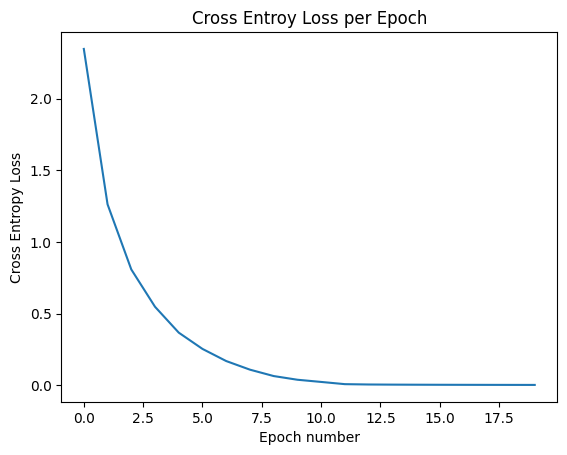

In [42]:
plt.plot(loss_data_avg)
plt.xlabel("Epoch number")
plt.ylabel("Cross Entropy Loss")
plt.title("Cross Entroy Loss per Epoch")

In [43]:
def evaluate_mode(train, test, model):
    x_train, y_train = train_data[:]
    x_test, y_test = test_data[:]
    pred_y_train = model_nn(x_train)
    pred_y_test = model_nn(x_test)
    train_acc = (pred_y_train.argmax(axis=1) == y_train.argmax(axis=1)).sum() / len(y_train) * 100
    test_acc = (pred_y_test.argmax(axis=1) == y_test.argmax(axis=1)).sum() / len(y_test) * 100
    print("Train set:", len(x_train))
    print("Test set:", len(x_test))
    print(f"Train data accuracy: {train_acc.numpy():.2f}%")
    print(f"Test data accuracy: {test_acc.numpy():.2f}%")
    return train_acc, test_acc


In [44]:
evaluate_mode(train_data, test_data, model_nn)

Train set: 27455
Test set: 7172
Train data accuracy: 100.00%
Test data accuracy: 77.77%


(tensor(100.), tensor(77.7747))

In [22]:
torch.save(model_nn.state_dict(), r"best_models\fc_nn.pt")

In [23]:
new_model = SMNN()
new_model.load_state_dict(torch.load(r"best_models\fc_nn.pt"))

<All keys matched successfully>

In [18]:
grid_model = NeuralNetClassifier(SMNN,
                                 criterion=nn.CrossEntropyLoss,
                                 max_epochs=20,
                                 batch_size=16,
                                 verbose=False
)

In [19]:
param_grid = {'optimizer': [optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta, 
                            optim.Adam, optim.Adamax, optim.NAdam],
}

In [25]:
grid = GridSearchCV(estimator=grid_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(train_data)

ValueError: 
All the 21 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\phan\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 684, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: NeuralNetClassifier.fit() missing 1 required positional argument: 'y'


In [14]:
X_train.shape, y_train.shape

(torch.Size([27455, 784]), torch.Size([27455, 25]))

In [15]:
X_train.dtype, y_train.dtype

(torch.float64, torch.float64)

torch.Tensor